<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : Natural Language Processing On Subreddit Posts
___
<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/marktwain.jpg' width = 75%>
<p/>

**Problem Statement**

`With the overflowing of information in the current world , we often find it hard to discern between what is real and fake , what is true and false and what is the full story and selective story. Often , we will find rouge players using misleading words to mix into sentences to arouse sentiments or misinformed the public so that the desired reactions could be derived from their victims.
As Data Scientist , are will able to experiment various modelling and processing technique , so that we are able to create well performed text processing model to help the enmass to better differentiate between fake news and real news?`

**Model Explored**

|Technique|Models|Description|
|---|---|---|
|Tokenisation| Random Forest Classifier|Text vectorization|
|Word Embedding|Bi Direction LSTM|Create Own Embedding|
|Word Embedding|Universal Sentence Encoder|Transfer Learning|

**Evaluation Metrics**

`Since this is a classification model , we will evaluate how will our model will perform in classifying between a Fake News and World News. We will scrape the data from reddit and preprocess it to be ready for modelling. Depending on the preprocessing method, different evaluation metric will be used accordingly.`
  * `For Imbalanced Data : F1 Score , Precision , AUC`
  * `For Balanced Data : F1 Score , Accuracy`
  * `Others Metrics : Recall Score`


**Workflow Process**  
1. `Create a function to automatically scrape subreddit.`
2. `Preprocess the data`
    * `2.1  Remove Stopwords , punctuation , numbers , accented words`
    * `2.2  Remove Leaked words`
    * `2.3  Remove sentence with 1 word`
    * `2.4  Checking for Data Imbalance`
3. `Numerical Encoding the words`
  * `3.1 Tokenization (For RandomForest)`
  * `3.2 Emebedding (For LSTM , Universal Sentence Encoder)`

4. `Create Model`
  *  `4.1 Hyperparameter tuning`
  *  `4.2 Input encoded text and output predictions`

5. `Evaluating Model`
  * `Visualising sentence that model guess wrongly.`
  * `Visualing embedded words.`
  * `Checking loss curves for overfitting.`
  * `Checking evaluation metrics.`

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [132]:
# Platform Interface
import time
from time import sleep
import requests
import pickle
import os

import pandas as pd
import numpy as np
import random
import itertools

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer , TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , confusion_matrix , roc_curve , auc
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
import tensorflow_hub as hub

!pip3 install --quiet tensorflow-text
import tensorflow_text as text


pd.set_option('display.max_colwidth' , 300)

In [133]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [134]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [135]:
def ngram_generator(df , ngram , subreddit = None):
  
  """
  This function contains 2 actions in order to process the word into visualiation base on the ngram count.
  1. CountVectorize & Transform Data
  2. Convert Data back to Matrix
  """
  
  if subreddit == None:
    cvec = CountVectorizer(ngram_range=(ngram,ngram))
    cvec.fit(df['title'])
    transformed = cvec.transform(df['title'])

  if subreddit == 'fake':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 0]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 0]['title'])

  elif subreddit == 'world':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 1]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 1]['title'])

  df_transformed = pd.DataFrame(transformed.todense(),
                                columns = cvec.get_feature_names())
  
  return df_transformed

In [136]:
def ngram_visualizer(df1 , df2 , df3):

  '''
  df1 = Main DF
  df2 = Fakenews
  df3 = Worldnews
  '''
  fig , ax = plt.subplots(1 , 3 , figsize = (24,10))

  df1.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[0])
  ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

  df2.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[1] , color = 'lightblue')
  ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

  df3.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[2] , color = 'green')
  ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

In [137]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [138]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [139]:
def tf_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [140]:
def plot_roc_curve_keras(model , X_test , y_test): 

  y_proba = model.predict(X_test).ravel()

  fpr , tpr , thresholds = roc_curve(y_test , y_proba)
  auc_score = auc(fpr , tpr)

  print('AUC:' , auc_score)
  plt.plot(fpr,tpr) 
  plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    

In [141]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = 'training loss')
  plt.plot(epochs , val_loss , label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = 'training accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

In [142]:
# df_fakenews = red_scrap('fakenews')

In [143]:
# df_worldnews = red_scrap('worldnews')

In [144]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [145]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/dataset/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/dataset/worldnews.csv

--2021-09-24 15:41:12--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/dataset/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3527243 (3.4M) [text/plain]
Saving to: ‘fakenews.csv.2’

fakenews.csv.2      100%[===================>]   3.36M  --.-KB/s    in 0.03s   

2021-09-24 15:41:12 (108 MB/s) - ‘fakenews.csv.2’ saved [3527243/3527243]

--2021-09-24 15:41:12--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/dataset/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... co

In [146]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [147]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [148]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [149]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [150]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Can you guess the fake?
1 Garbage For Your Mind = Lamestream Media
2 Prof dave farina believes that fake news is one of the biggest issues we face in the 21st century
3 World largest snake found in Amazon river, no it is photoshopped
4 Karen Has A Question for You... What is Fake? What is Real?
5 Chinese Agents Spread Messages That Sowed Virus Panic in U.S., Officials Say
6 WHY?
7 The WHO declared it a PHEIC on Jan 30. Trump banned travel from china Jan 31. The WHO's previous declarations had also minimized the possibility of infection in developed nations. This guy is straight faced lying.
8 Anti-vaccine in France
9 If Soleimani was a 'terrorist' why was he fighting ISIS?


In [151]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 باقات وعروض يمن نت | احصل على افضل عروض وباقات يمن نت
1 NRL 2021 finals week one: Melbourne Storm demolish Manly Sea Eagles – as it happened – The Guardian
2 Travel + Leisure debuts online booking and subscription memberships
3 جورج قرداحي يتحدث بعد اختياره وزير للإعلام ضمن تشكيل الحكومة اللبنانية
4 Joe Biden Nominates More Historic Firsts To Be Lifetime Federal Judges
5 Keo, A Multiplayer Car Combat Game, Enters Early Access This Month
6 Apple rebuffs Epic request to restore Fortnite developer account in South Korea
7 ‘The Queen’s Gambit’ Leads Winners On Night One Of Creative Arts Emmys
8 Nişan üzüyünün əsl mənası nədir?
9 Ole: Ronaldo will 'definitely' play vs Newcastle


# 2.0 Data Cleaning and Preprocessing
___

In [152]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [153]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  What are some instagram pages that are known to share/post fake news
Remove Numeric , lowercase       :  ['what', 'are', 'some', 'instagram', 'pages', 'that', 'are', 'known', 'to', 'share', 'post', 'fake', 'news']
Remove Punctuation               :  ['what', 'are', 'some', 'instagram', 'pages', 'that', 'are', 'known', 'to', 'share', 'post', 'fake', 'news']
Remove Stop words                :  ['instagram', 'pages', 'known', 'share', 'post', 'fake', 'news']
Stem the words & joint the words :  instagram page known share post fake news
-----------------------------------------
Original Sentence                :  From what I have seen this is not the Tulsa rally but can not confirm.. is this real?
Remove Numeric , lowercase       :  ['from', 'what', 'have', 'seen', 'this', 'is', 'not', 'the', 'tulsa', 'rally', 'but', 'can', 'not', 'confirm', 'is', 'this', 'real']
Remove Punctuation               :  ['from', 'what', 'have', 'seen', 'this', 'is', 'not', 'th

### 2.2 Preprocess Function for data
___

In [154]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [155]:
preprocessing(df_fakenews , 'title')

In [156]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [157]:
preprocessing(df_worldnews , 'title')

In [158]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Merging Datasets
___

In [159]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2899
Shape of Combined Datasets : (2899, 2)
SIze of Combined Datasets : 5798


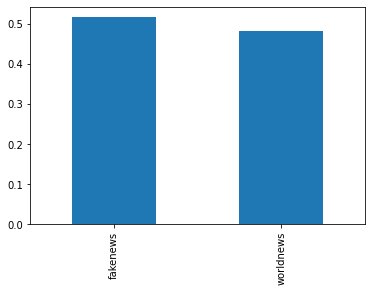

In [160]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [161]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.4 Removing Sentence with less than 2 word
___

* The average length of title is around 10 words.
* At the 75th percentile , the number of words are less than 20.
* We will `limit the length of the sentence to 30` in later parameter settings

In [162]:
df_main['len of sentence'] = [len(sentence.split(' ')) for sentence in df_main['title']]
df_fakenews['len of sentence'] = [len(sentence.split(' ')) for sentence in df_fakenews['title']]
df_worldnews['len of sentence'] = [len(sentence.split(' ')) for sentence in df_worldnews['title']]

In [163]:
print('No. of Sentence with 1 word :' , len(df_main[df_main['len of sentence'] == 1]))
print('Longest Sentence :' , df_main['len of sentence'].max())
df_main[df_main['len of sentence'] == 1].head(10)

No. of Sentence with 1 word : 140
Longest Sentence : 46


,title,subreddit,len of sentence
11,,0,1
31,hhhmmm,0,1
40,propaganda,0,1
58,reddit,0,1
116,guid,0,1
157,make,0,1
166,cnn,0,1
193,,0,1
220,real,0,1
245,world,0,1


Text(0.5, 1.0, 'Combine DF title length')

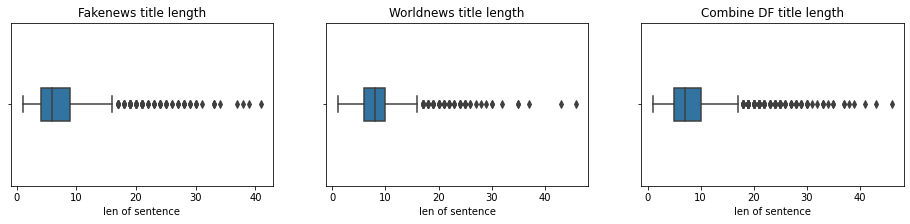

In [164]:
fig , ax = plt.subplots(1,3, figsize = (16,3))

sns.boxplot(data = df_fakenews,
            x = 'len of sentence',
            width = 0.2,
            ax = ax[0])

sns.boxplot(data = df_worldnews,
            x = 'len of sentence',
            width = 0.2,
            ax = ax[1])

sns.boxplot(data = df_main,
            x = 'len of sentence',
            width = 0.2,
            ax = ax[2])


ax[0].set_title('Fakenews title length')
ax[1].set_title('Worldnews title length')
ax[2].set_title('Combine DF title length')

In [165]:
df_main = df_main[df_main['len of sentence'] > 2]

In [166]:
# !pip install unidecode
# import unidecode

### 2.5 Visualising Popular Words
___

In [167]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])

cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

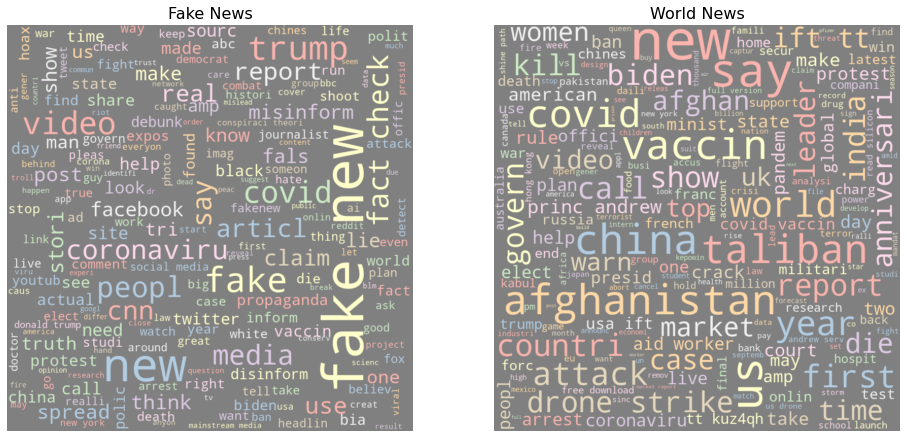

In [168]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [169]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (2605, 38597)
DF Shape for fakenews Vocab  : (1293, 19458)
DF Shape for worldnews Vocab  : (1312, 20943)


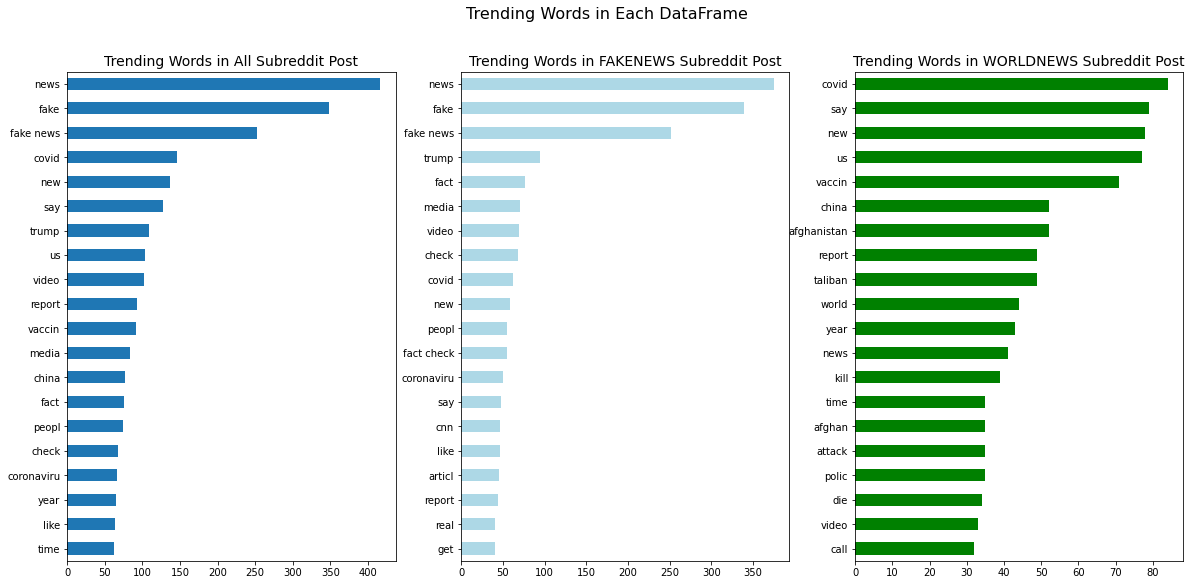

In [170]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

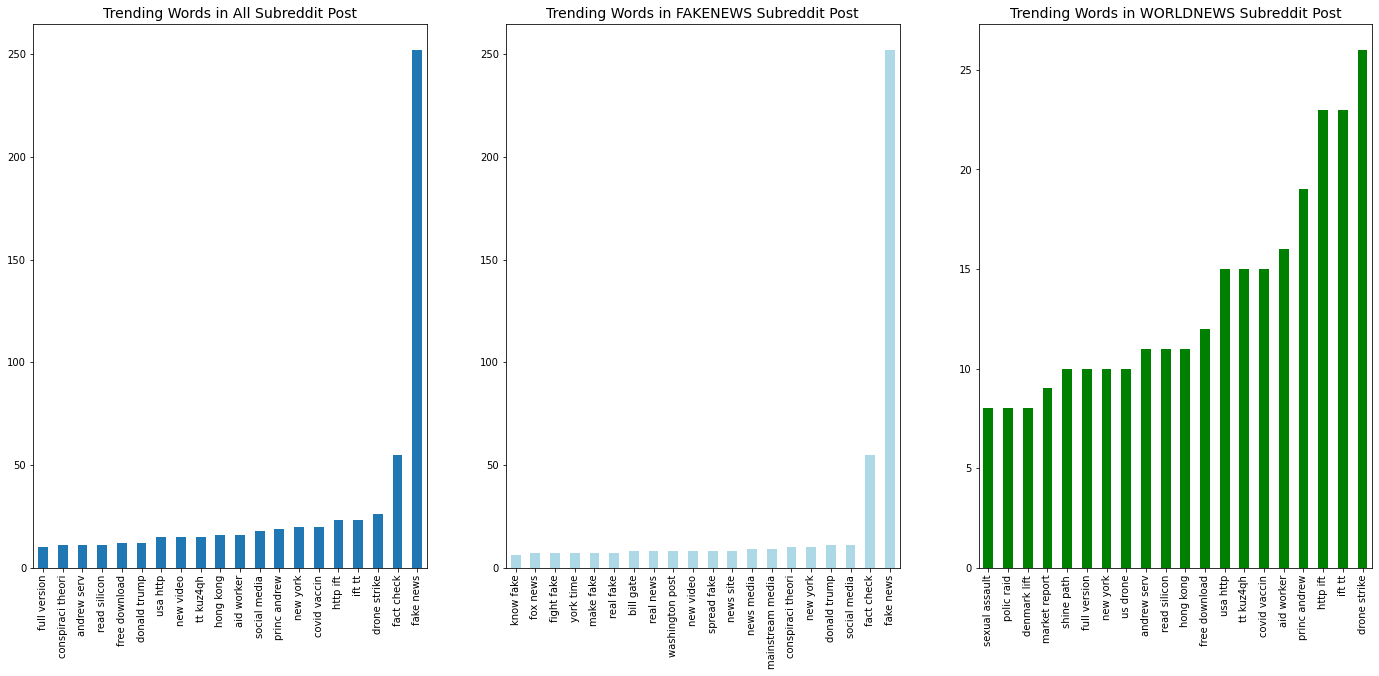

In [171]:
df_main_vocab_n2 = ngram_generator(df_main , 2)
df_world_vocab_n2 = ngram_generator(df_main , 2 , 'world')
df_fake_vocab_n2 = ngram_generator(df_main , 2 , 'fake')

ngram_visualizer(df_main_vocab_n2 , df_fake_vocab_n2 , df_world_vocab_n2)

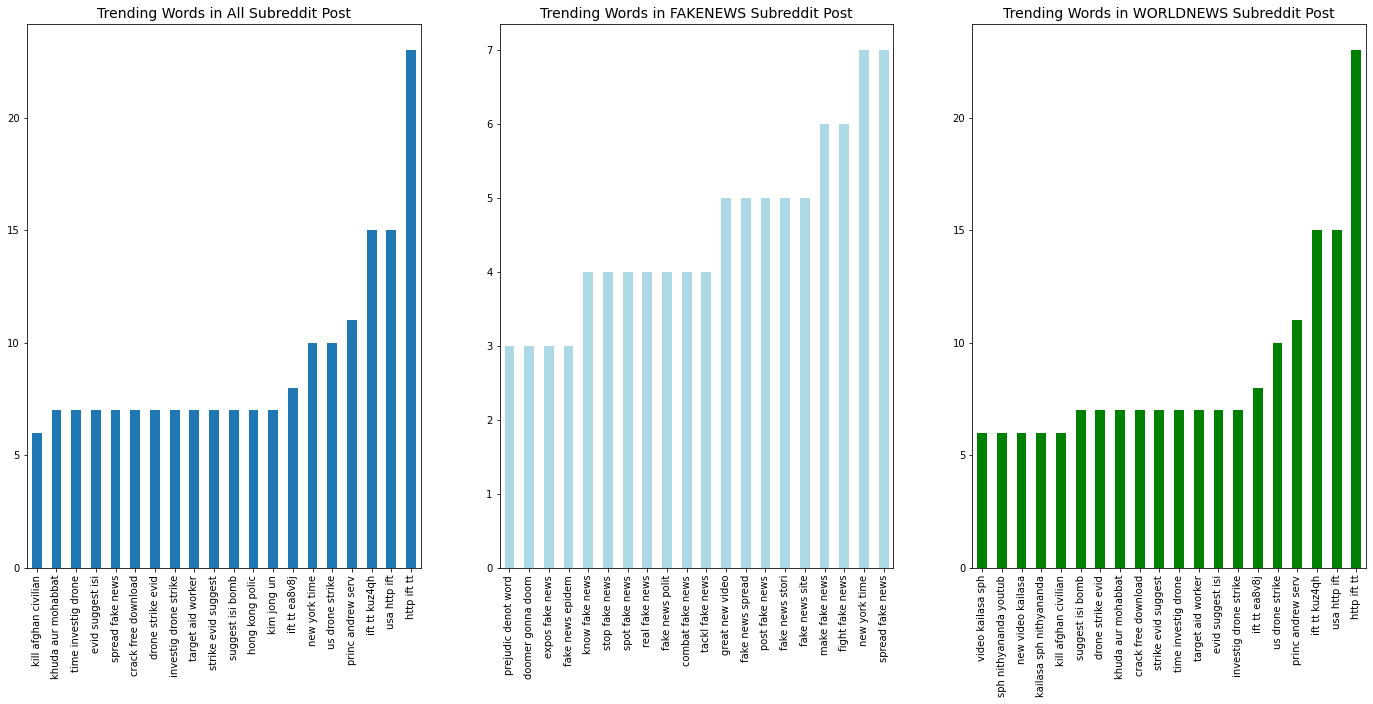

In [172]:
df_main_vocab_n3 = ngram_generator(df_main , 3)
df_world_vocab_n3 = ngram_generator(df_main , 3 , 'world')
df_fake_vocab_n3 = ngram_generator(df_main , 3 , 'fake')

ngram_visualizer(df_main_vocab_n3 , df_fake_vocab_n3 , df_world_vocab_n3)

### 2.6 Removing Data Leakage
___

In [173]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_main))
df_main = df_main.loc[~df_main['title'].str.contains('fake|news|new|say|http|ift|https')]
df_main.head()
print('Data Count After removal leaked words:' , len(df_main))

Data Count Before removal leaked words: 2605
Data Count After removal leaked words: 1847


### 2.7 Splitting Data
___

In [174]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

print('X_train Shape : ' , X_train.shape)
print('X_test Shape : ' , X_test.shape)
print('y_train Shape : '  , y_train.shape)
print('y_test Shape : ' , y_test.shape)

X_train Shape :  (1477,)
X_test Shape :  (370,)
y_train Shape :  (1477,)
y_test Shape :  (370,)


### 2.8 Checking for Data Imbalance
___

After removing leaked words and aplitting the dataset , the dataset between Fakenews and World News is quite evenly split between Fake and World News at 42% to 57%. We will not smote the dataset in this run.

In [175]:
# We Have Imbalance Data , need to SMOTE before that.
print(f' Fake News % : {y.value_counts(normalize=True)[0]*100}')
print(f' World News % : {y.value_counts(normalize=True)[1]*100}')

 Fake News % : 42.230644288034654
 World News % : 57.76935571196535


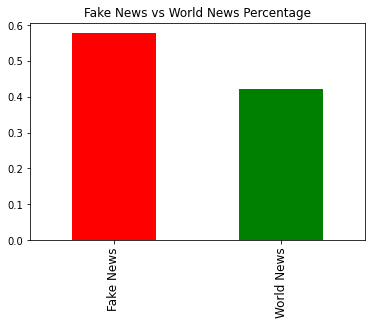

In [176]:
ax = y.value_counts(normalize=True).plot(kind = 'bar' , color = ['red' , 'green'])
ax.set_xticklabels(['Fake News' , 'World News'],fontsize=12);
ax.set_title('Fake News vs World News Percentage');

#3.0 Modelling with Random Forest

In [177]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
#               'tfidf__smooth_idf' : [True , False],
#               'tfidf__sublinear_tf' : [True , False],
#               'model__min_samples_split' : np.arange(2 , 10 , 2),
#               'model__min_samples_leaf' : np.arange(1 , 5 , 1),
#               'model__n_estimators' : np.arange(50 , 80 , 10),
#               'model__max_features' : ['log2' , 'sqrt' , 'auto'],
#               'model__max_depth' : [3,5,7]              
# }

# # Fitting the model
# model = GridSearchCV(estimator = pipe,
#                      param_grid = param_grid,
#                      cv = 5,
#                      n_jobs =-1)

# model.fit(X_train , y_train)
# # # Model Prediction
# y_pred = model.predict(X_test)

In [178]:
# model.best_params_

In [179]:
# # Saving the Model
# pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [180]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.1 Fine Tuning Grid Search Parameter
___

In [181]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__min_df' : range(5,10),
#               'vect__max_df' : np.arange(0.90 , 1.0 , 0.1),
#               'model__min_samples_split' : np.arange(1 , 5 , 1),
#               'model__min_samples_leaf' : np.arange(6 , 8 , 1),
#               'model__n_estimators' : np.arange(90 , 120 , 10),
#               'model__max_features' : ['sqrt'],
#               'model__max_depth' : [None]              
# }

# # Fitting the model
# model_2 = GridSearchCV(estimator = pipe,
#                        param_grid = param_grid,
#                        cv = 5,
#                        n_jobs =-1)

# model_2.fit(X_train , y_train)
# # # Model Prediction
# y_pred_2 = model_2.predict(X_test)

In [182]:
# model_2.best_params_

In [183]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 5 , max_df = 0.90 , ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split= 3,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 110,
                                                       max_features = 'sqrt'))
])


model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

### 3.2 Evaluating Random Forest Classifier Model Score
___

{'Accuracy': 0.7648648648648648,
 'F1 Score': 0.8191268191268193,
 'Precision': 0.7378277153558053,
 'Recall': 0.9205607476635514}

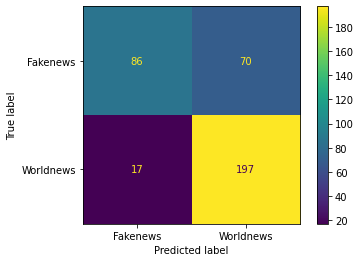

In [184]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

rfc_score = eval_classification(y_true=y_test , y_pred = model_RFC_pred)
rfc_score

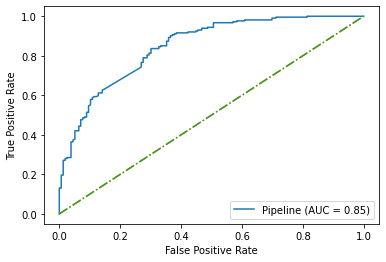

In [185]:
rfc_plot = plot_roc_curve(model_RFC , X_test , y_test)
plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');

### 3.3 Visualing Most Wrongly Predicted Reddit Post
___

In [186]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]
worldnews_prediction = [y_proba[i][1] for i in range(len(X_test))]

In [187]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_score' : fakenews_prediction,
                              'Worldnews_score' : worldnews_prediction})

In [188]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_score' , ascending = False).drop('Worldnews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Fakenews_score
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0,0.792264
1069,pakistan report fresh coronaviru case death,1,0,0.718457
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0,0.706175
1346,facebook apolog put primat label video black men,1,0,0.697677
10,ben affleck push intrus fan tri click selfi jennif lopez venic airport,1,0,0.646492
872,orfium project offic elstudio,1,0,0.626426
710,btc giveaway promot like page comment btc address,1,0,0.614407
713,us post gener critic america patriot opinion,1,0,0.561447
1116,declar covid outbreak among yellowknif homeless popul,1,0,0.558094
1199,singapor paus reopen expert suggest bolder covid strategi,1,0,0.558094


In [189]:
# Visualing Most Wrong fake News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Worldnews_score' , ascending = False).drop('Fakenews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Worldnews_score
261,pocahonta first winner hunger game,0,1,0.811475
74,afghan ambassador daughter bruis blood mark real,0,1,0.775952
405,zombi fliegen dänemark entdeckt soll ja bald auch auf den menschen bertragbar sein wobei der pilz dann wohl nicht die genitalien de wirt frisst sondern sein gehirn können all querdenk und coronaleugn aufatmen,0,1,0.741483
1486,misconcept cast system india,0,1,0.733437
373,due covid travel restrict american forc hold coup local year,0,1,0.726952
814,polic vs hypocrisi polic offic could face death penalti shoot rayshard brook,0,1,0.723362
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1,0.703940
1330,thai seal murder cave rescu cover last year,0,1,0.699704
32,one day fewer hospit make trend especi less decreas,0,1,0.687892
1085,wonder solut could,0,1,0.686425


### 3.4 Top 30 Predictor Words
___

In [190]:
#Accessing pipeline Vectorizier to get the words 
vect = model_RFC.named_steps['vect']
words = vect.get_feature_names()

# Accessing pipeline model to get the feature score
classifier = model_RFC.named_steps['model']
rfc_feature = classifier.feature_importances_

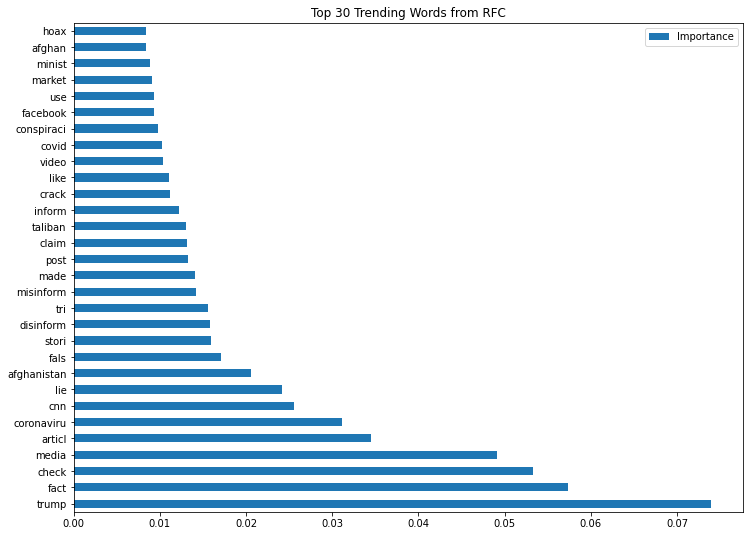

In [191]:
df_popular_word = pd.DataFrame(index = words,
                               data = {'Importance' : rfc_feature})


df_popular_word.sort_values('Importance' , ascending = False)[:30].plot(kind = 'barh' , figsize = (12,9))
plt.title('Top 30 Trending Words from RFC');

# 4.0 Modelling with LSTM
___

### 4.1 Creating LSTM Model
___

1. Create a Text Vectorizer layer
  * TF had an in built text vectorizer layer which preprocess the sentences. This include removing case , lowering letter and parameters to set no. of words in our vocab and sentence.
2. Create an embedding layer.
  * This create a layer where it convert the tokens into word vectors.
3. Create LSTM layers and Hidden layers.
4. Create output layer with 1 output.  

In [192]:
max_vocab_length = 120  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

text_vectorizer.adapt(X_train) # so your text vectorization will create a vocab.


embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length,
                                      name = 'embedding')

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

model_lstm = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [193]:
model_lstm.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           15360     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 155,457
Trainable params: 155,457
Non-trainable params: 0
_____________________________________________

In [194]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [195]:
history_lstm = model_lstm.fit(X_train,
                              y_train,
                              epochs = 20,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])

Saving Tensorboard log files to model_log/lstm_model/20210924-154125
Epoch 1/20
47/47 [==============================] - 10s 110ms/step - loss: 0.6564 - accuracy: 0.6154 - val_loss: 0.6023 - val_accuracy: 0.6865
Epoch 2/20
47/47 [==============================] - 2s 53ms/step - loss: 0.5460 - accuracy: 0.7414 - val_loss: 0.4855 - val_accuracy: 0.7703
Epoch 3/20
47/47 [==============================] - 3s 53ms/step - loss: 0.4851 - accuracy: 0.7867 - val_loss: 0.4702 - val_accuracy: 0.7865
Epoch 4/20
47/47 [==============================] - 3s 54ms/step - loss: 0.4623 - accuracy: 0.7840 - val_loss: 0.4708 - val_accuracy: 0.7919
Epoch 5/20
47/47 [==============================] - 2s 53ms/step - loss: 0.4443 - accuracy: 0.7908 - val_loss: 0.4821 - val_accuracy: 0.7649
Epoch 6/20
47/47 [==============================] - 3s 55ms/step - loss: 0.4546 - accuracy: 0.7894 - val_loss: 0.4715 - val_accuracy: 0.7811
Epoch 7/20
47/47 [==============================] - 3s 54ms/step - loss: 0.4355 - a

In [196]:
model_lstm_pred = model_lstm.predict(X_test)

### 4.2 Evaluating LSTM Model Score
___

In [197]:
lstm_score = eval_classification(y_test , tf.squeeze(tf.round(model_lstm_pred)))
lstm_score

{'Accuracy': 0.7783783783783784,
 'F1 Score': 0.8047619047619048,
 'Precision': 0.8203883495145631,
 'Recall': 0.7897196261682243}

Confusion matrix, without normalization
[[119  37]
 [ 45 169]]


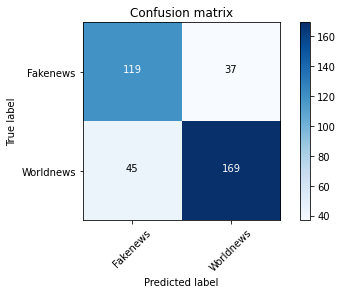

In [198]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_lstm_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

AUC: 0.8434729211598371


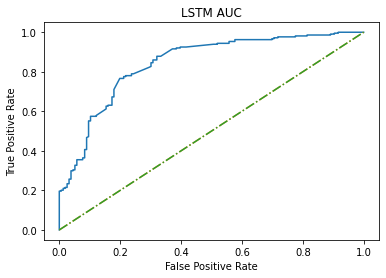

In [199]:
plt.title('LSTM AUC')
lstm_plot = plot_roc_curve_keras(model_lstm , X_test , y_test)

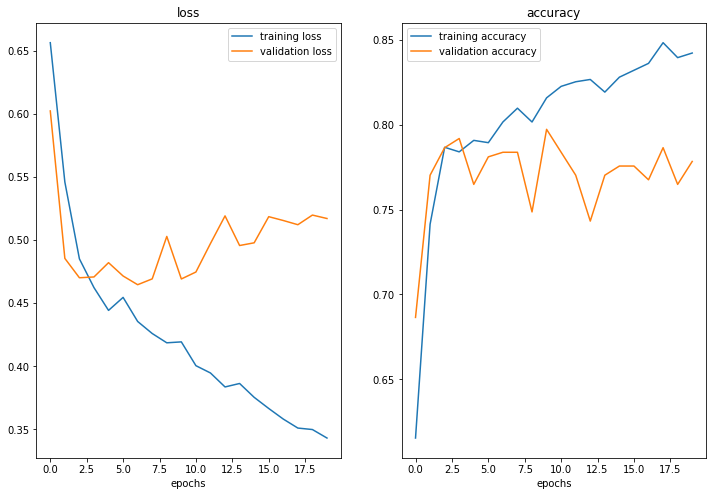

In [200]:
# We could observed that for this LSTM Model , the model is overfitted.
# The training acurracy keep increasing as the validation accuracy stagnate around 0.80.
# Also it could be observed that as the number of epochs increase, the loss for the validation started increase as well.
plot_loss_curves(history_lstm)

### 4.3 Visualising Most Wrong Predicted Reddit Post
___

In [201]:
y_proba = model_lstm.predict(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [202]:
df_prediction_lstm  = pd.DataFrame({'Title' : X_test,
                                  'Target' : y_test,
                                  'Prediction' : tf.squeeze(tf.round(model_lstm_pred)),
                                  'Prediction_score' : fakenews_prediction})

In [203]:
# Visualing Most Wrong World News (LSTM Model)
# Note Prediction Score refer to the model predicting either 0 or 1, While Fakenews Score or worldnews score predict whether it is Fakenews or Worldnews

df_most_right_wrong_lstm = df_prediction_lstm[df_prediction_lstm['Target'] != df_prediction_lstm['Prediction']].sort_values(by = 'Prediction_score' , ascending = False)
df_most_right_wrong_lstm.tail(10)

,Title,Target,Prediction,Prediction_score
1163,fulli vaccin covid case philippin receiv sinovac vaccin,1,0.0,0.124384
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0.0,0.105098
1000,case regist asaduddin owaisi hate speech,1,0.0,0.048741
872,orfium project offic elstudio,1,0.0,0.042587
568,happen gener facebook websit xml sitemap file,1,0.0,0.038103
10,ben affleck push intrus fan tri click selfi jennif lopez venic airport,1,0.0,0.022267
1051,daili covid case like soon exceed next week crucial singapor,1,0.0,0.018340
1346,facebook apolog put primat label video black men,1,0.0,0.011512
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0.0,0.009689
1069,pakistan report fresh coronaviru case death,1,0.0,0.007406


In [204]:
# Visualing Most Wrong Fake News (LSTM Model)
df_most_right_wrong_lstm.head(10)

,Title,Target,Prediction,Prediction_score
814,polic vs hypocrisi polic offic could face death penalti shoot rayshard brook,0,1.0,0.983766
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1.0,0.980895
74,afghan ambassador daughter bruis blood mark real,0,1.0,0.980091
32,one day fewer hospit make trend especi less decreas,0,1.0,0.977376
373,due covid travel restrict american forc hold coup local year,0,1.0,0.961879
780,instagram girl accus cv la habra falsifi covid result,0,1.0,0.944089
1082,anti vaxxer russia behind viral covid conspiraci theori,0,1.0,0.897514
1389,know truth histori propaganda pleas see comment section,0,1.0,0.888258
261,pocahonta first winner hunger game,0,1.0,0.870121
1330,thai seal murder cave rescu cover last year,0,1.0,0.852493


### 4.4 Visualing Word Embedding
___

In [205]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
words_in_vocab = text_vectorizer.get_vocabulary()
embed_weights = model_lstm.get_layer('embedding').get_weights()[0]
embed_weights.shape

(120, 128)

In [206]:
# # Create a checkpoint from embedding, the filename and key are the
# # name of the tensor.
# log_dir = '/content/sample_data/'
# weights = tf.Variable(lstm_model.get_layer('embedding').get_weights()[0][1:])

# checkpoint = tf.train.Checkpoint(embedding=weights)
# checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

In [207]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 4.4.1 Embedding Projector for 120 Vocab for World and Fake News
___

* The explained variance for this clustering is around 45% , using a vocab limit of 120.
* The vocabs are more representative for our current quantity of data , which is around 2000 sentences.
* 2 clear distinct cluster could be observed : Trump on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_120vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_120vocab.PNG' width = 100%>

#### 4.4.2 Embedding Projector for 6000 Vocab for World and Fake News
___

* The explained variance for this clustering is around 22% , using a vocab limit of 6000.
* The vocabs are less representative for our current quantity of data , which is around 2000 sentences. The Vocab are more diluted across a smaller dataset , thus a lower explained variance observed.
* 2 clear distinct cluster could be observed : CNN on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_6000vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_6000vocab.PNG' width = 100%>

# 5.0 Modelling with Tensorflow Universal Sentence Encoder
___

### 5.1 Loading Universal Sentence Encoder from Tensorflow Hub
___

In [208]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

### 5.2 Evaluating Universal Sentence Encoder Score
___

In [209]:
max_vocab_length = 120 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [210]:
# random_sentences = random.sample(df_main['title'].to_list() , 3)

# for sentence in random_sentences:
#   print(sentence)
#   print(embed([sentence]))
#   print('------------------------------------------------')

In [211]:
model_use = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

model_use.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [212]:
model_use.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [213]:
history_tf = model_use.fit(X_train,
                         y_train,
                         epochs = 20,
                         validation_data = (X_test , y_test),
                         callbacks = [create_tensorboard_callback('model_log' , 'use_model')])

Saving Tensorboard log files to model_log/use_model/20210924-154257
Epoch 1/20
47/47 [==============================] - 5s 54ms/step - loss: 0.6892 - accuracy: 0.5653 - val_loss: 0.6836 - val_accuracy: 0.6622
Epoch 2/20
47/47 [==============================] - 0s 10ms/step - loss: 0.6786 - accuracy: 0.6696 - val_loss: 0.6732 - val_accuracy: 0.6946
Epoch 3/20
47/47 [==============================] - 0s 9ms/step - loss: 0.6682 - accuracy: 0.6940 - val_loss: 0.6622 - val_accuracy: 0.7216
Epoch 4/20
47/47 [==============================] - 0s 11ms/step - loss: 0.6572 - accuracy: 0.6906 - val_loss: 0.6503 - val_accuracy: 0.7324
Epoch 5/20
47/47 [==============================] - 0s 10ms/step - loss: 0.6451 - accuracy: 0.7021 - val_loss: 0.6375 - val_accuracy: 0.7378
Epoch 6/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6322 - accuracy: 0.7163 - val_loss: 0.6234 - val_accuracy: 0.7568
Epoch 7/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6187 - accur

In [214]:
model_use_pred = model_use.predict(X_test)

In [215]:
use_score = eval_classification(y_test , tf.squeeze(tf.round(model_use_pred)))
use_score

{'Accuracy': 0.8243243243243243,
 'F1 Score': 0.8571428571428571,
 'Precision': 0.8091286307053942,
 'Recall': 0.9112149532710281}

Confusion matrix, without normalization
[[110  46]
 [ 19 195]]


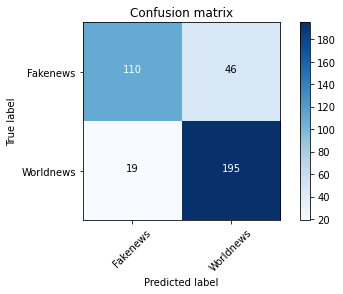

In [216]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_use_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

AUC: 0.8835070692547329


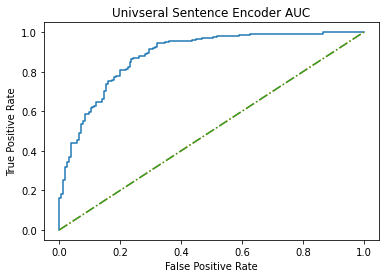

In [217]:
plt.title('Univseral Sentence Encoder AUC')
use_plot = plot_roc_curve_keras(model_use , X_test , y_test)

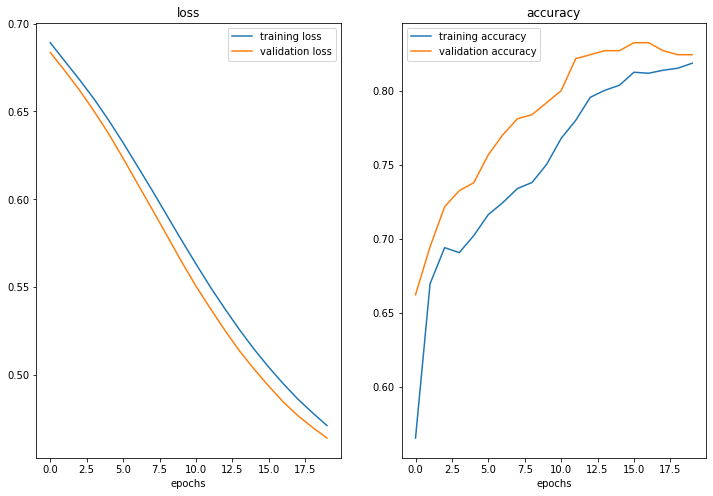

In [218]:
# We could observed that for this USE Model , the model is performing quite well with the validation accuracy scoring better than the training.
# The validation accuracy starts to pleateau around 0.82 , however it is still projecting in the right direction.
# Also it could be observed that as the number of epochs increase, the loss for the validation started decrease as well.
# We could increase number of epochs and fine tune the learning rate to experiment further.

plot_loss_curves(history_tf)

# 6.0 Comparing Model Results
___

### 6.1 Using Models to Predict Random Sentences
___

In [219]:
def sentence_prediction(df):

  sample_sentence = random.sample(df['title'].to_list() , 1)

  sample_prediction_rfc = model_RFC.predict_proba(sample_sentence)
  sample_prediction_lstm = model_lstm.predict(sample_sentence)
  sample_prediction_use = model_use.predict(sample_sentence)

  print('Sample Sentence :' , sample_sentence)
  print('----------------------------')
  print('RFC MODEL :' , sample_prediction_rfc[0])  
  print('LSTM MODEL :' , sample_prediction_lstm[0])  
  print('USE MODEL :' , sample_prediction_use[0])

In [220]:
sentence_prediction(df_main)

Sample Sentence : ['lebanon govern announc friday pm design tell local media']
----------------------------
RFC MODEL : [0.54402192 0.45597808]
LSTM MODEL : [0.89761794]
USE MODEL : [0.6197559]


### 6.2 Comparing Result in Tensorboard
___

* From the `Universal Sentence Encoder` , we could observed that it is not overfitted as compared to the Bi-directional LSTM Model.
* Given more epochs and a finer learning rate , the `USE model` could have continue to improve in its accuracy based on the current learning trajectory.
* For the `LSTM Model` , we could experiment with more hidden layers and observed the accuracy.

In [221]:
!tensorboard dev upload --logdir ./model_log/ \
  --name 'NLP Modelling for Fake and World News' \
  --description 'Training Results from LSTM and USE Models' \
  --one_shot

2021-09-24 15:43:23.961519: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-24 15:43:23.961571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7b4a56a3fb9c): /proc/driver/nvidia/version does not exist

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_log/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL t


<figure>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/Model%20Comparison.PNG' width = 100%>



### 6.3 Comparing 3 Models Metrics
___

* The pre-trained model from Universal Sentence Encoder performed significantly consistent compared to the other 2 models.
* There is still room for improvement as we can tuned the learning rate and increase the number of epochs.

In [222]:
df_model_summary  = pd.DataFrame({'RFC' : rfc_score,
                                  'Bi-Dir LSTM' : lstm_score,
                                  'Universal Sentence Encoder' : use_score})

df_model_summary = df_model_summary.T
df_model_summary

,Accuracy,Precision,Recall,F1 Score
RFC,0.764865,0.737828,0.920561,0.819127
Bi-Dir LSTM,0.778378,0.820388,0.789720,0.804762
Universal Sentence Encoder,0.824324,0.809129,0.911215,0.857143


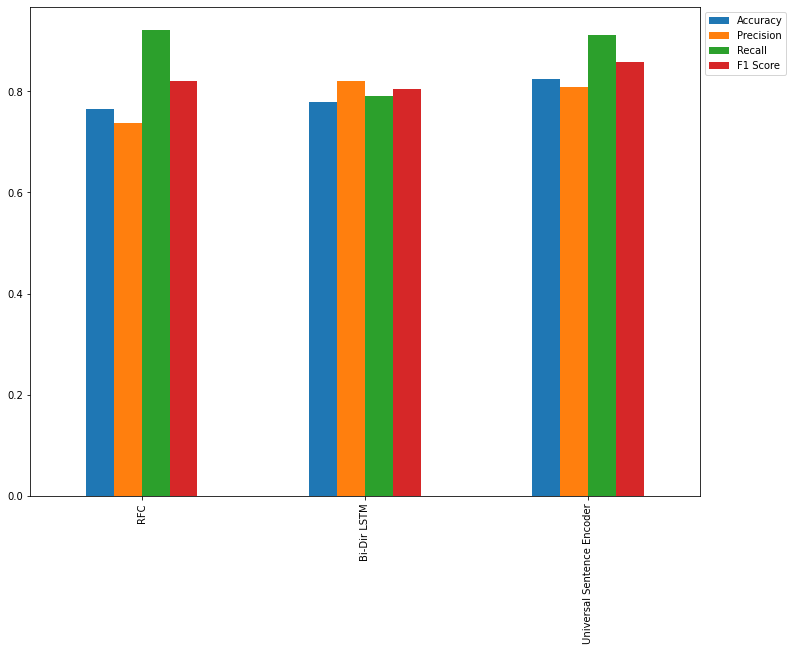

In [223]:
df_model_summary.plot(kind = 'bar' , figsize = (12,9)).legend(bbox_to_anchor = (1,1))

### 6.4 Visualing Word Vectors
___

* From earlier embedding projector , we could observed how each word is linked to each other via vectors after the tokens are parse through the embedding layers.
* From our model , we have define 128 vectors for each words.
* From the below example, we picked 9 closely related words to fakenews and 1 word related to world news.

In [224]:
word_list = ['trump' , 'articl' , 'trump' , 'black' , 'facebook' , 'inform' , 'check' , 'offic' , 'facts' , 'afghanistan']
embed_list = []
embed_list = [embedding(text_vectorizer([word]))[0][0] for word in word_list]

In [225]:
np.savetxt('embed.csv' , embed_list , delimiter=',')

In [226]:
# Sample tensor of a word vector
embed_list[0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-6.40371442e-02, -4.94116247e-02,  1.30734444e-01, -1.22758307e-01,
       -8.61029699e-02, -5.50381318e-02,  3.53970975e-02, -9.76893306e-02,
        7.72892833e-02, -1.14006385e-01, -5.50706759e-02, -5.89572564e-02,
        1.14300884e-01, -1.21665411e-01, -1.72354877e-01,  5.48595972e-02,
        1.01429865e-01, -6.39345646e-02, -1.39572904e-01,  1.00810938e-01,
        1.12664372e-01,  1.01998650e-01,  7.74860904e-02,  7.43982270e-02,
        4.16464061e-02, -6.30410463e-02, -1.28378719e-01, -1.30123764e-01,
       -6.06521256e-02, -7.88626149e-02, -2.82005519e-02,  4.33733501e-02,
       -9.68927145e-02, -6.45979941e-02, -8.49337280e-02,  1.21396355e-01,
       -1.37589902e-01, -1.69200137e-01,  7.29113892e-02,  1.23370804e-01,
        1.24409184e-01, -1.29629010e-02, -4.24333587e-02, -6.65207505e-02,
        3.53625156e-02, -7.38162473e-02, -1.30021065e-01, -1.04310118e-01,
        6.93248510e-02,  1.32817522e-01,  6.85673282

#### 6.4.1 Comparing word vectors across the 10 words for sample arrary
___

* We could observed that for the 1st 9 words which are closely related to each other, their vectors for certain arrays are very similiar.
* We could also observed that at the 10th row , which are not related to the 1st 9 words , often break away at certain arrays.

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/word_embed.PNG'>

# 7.0 Conclusion and recommendations
___

**Insights**

Our models performed relatively well in differentiating between post from fake news and world news. The 3 models performed consistently with accuracy between 78% - 83% and F1 score of 83% - 86% , with the transfer learning USE outperforming amongst all.

The differences or the part where the models are confused is probably due to common word associated to both side of the posts such as US , death , which is linked to the Afghan withdrawal , as well as Donald Trump. 

**Current Limitation**

As we could see from our word embedding , due to the limited amount of dataset at 2,000 dataset , the number of vocabs we had limited is set at `120` so as not to dilute the explained variance of the features. (Explained variance reduced to 22% as we increase the vocab limit to 6,000) If we do have more dataset , we could explore more relevant vocabs and have a better representation of the current challenges on various social media outlet, such as twitter , facebook or any popular forum , as a well as better cross studies on how effective are the fake words or fake posts arousing sentiments , moods and actions.

**Next Steps in improving model score**

* Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT.
* Experimenting with the pretrained GloVe embeddings.
* Getting more dataset
* Getting more quality dataset. For example , can we trained our model on actual world and fakes news first before using it to predict on these social media posts.

**Next Steps in model application**

Although the objective of this project was to attempt to explore techniques and model to classify posts from reddit, this could be further extended to more social mediam outlet such as twitter , facebook or relevant forums to assist in flushing out malicious fake and misformed news. This could also be further extended to other application as well such as detecting potential depression and suicidal posts.